In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('seaborn')
import sys
import os
sys.path.append(os.path.join(".."))
from module.topic_model_plus_class import Topic_Model_plus
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans, SpectralClustering, MeanShift, AffinityPropagation, DBSCAN, AgglomerativeClustering  
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [2]:
data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()),'data', 'SAFECOM_UAS_fire_data.csv'), index_col=0)

# Backup Method:
- summarize
- cluster: options are KMeans, spectral, mean shift, affinitypropagation,DBSCAN, BERTopic, HDBSCAN, agglomorative (also Gaussian Mixture and others)
- FMEA

In [3]:
summarized_cols = ['Extractive Summarized Narrative', 'Extractive Summarized Corrective Action'] #['Abstractive Summarized Narrative', 'Abstractive Summarized Corrective Action']
embedder = SentenceTransformer('all-mpnet-base-v2')

In [4]:
def graph_clusters(text, clusters, title=""):
    pca = PCA(n_components=2)
    two_dim = pca.fit_transform(text)

    scatter_x = two_dim[:, 0] # first principle component
    scatter_y = two_dim[:, 1] # second principle component

    fig, ax = plt.subplots()
    fig.set_size_inches(20,10)

    # color map for NUMBER_OF_CLUSTERS we have
    cmap = cm.tab20(np.linspace(0, 1, len(np.unique(clusters))))

    # group by clusters and scatter plot every cluster
    # with a colour and a label
    for group in np.unique(clusters):
        ix = np.where(clusters == group)
        ax.scatter(scatter_x[ix], scatter_y[ix], color=cmap[group], label=group)

    ax.legend()
    plt.xlabel("PCA 0")
    plt.ylabel("PCA 1")
    plt.title(title)
    plt.show()

In [5]:
def evaluate_cluster_methods(cluster_dict, cluster_params_dict, data, text_cols, embedder, graph=False):
    iterables = [list(cluster_dict.keys()), text_cols]
    ind = pd.MultiIndex.from_product(iterables, names=["Cluster Method", "Text Section"])
    results_df = pd.DataFrame({}, index=ind)
    sil_scores = []; db_scores = []; ch_scores = []; trained_models = []
    for cluster in tqdm(cluster_dict):
        for col in text_cols:
            cluster_model = cluster_dict[cluster](**cluster_params_dict[col][cluster])
            text = embedder.encode(data[col].to_list())
            labels = cluster_model.fit_predict(text)
            if len(np.unique(labels))<2 or len(np.unique(labels))>=len(text):
                sil_scores.append(np.nan)
                db_scores.append(np.nan)
                ch_scores.append(np.nan)
            else:
                sil_scores.append(silhouette_score(text, labels))
                db_scores.append(davies_bouldin_score(text, labels))
                ch_scores.append(calinski_harabasz_score(text, labels))
            trained_models.append(cluster_model)
            if graph: graph_clusters(text, labels, title=col)
    results_df['Silhouette Scores'] = sil_scores #close to one scores good
    results_df['Davies Bouldin Scores'] = db_scores #close to zero scores good
    results_df['Calinski Harabasz Scores'] = ch_scores #larger scores good
    return results_df, trained_models

In [6]:
cluster_dict = {'kmeans':KMeans, 'spectral':SpectralClustering,
                'mean_shift': MeanShift,'affinity': AffinityPropagation, 'DBSCAN': DBSCAN, 
                'aglommorative': AgglomerativeClustering}
cluster_params_dict = {'kmeans':{'algorithm': 'full', 'init': 'k-means++', 'n_clusters': 4, 'n_init': 5, 'random_state': 1, 'tol': 0.01}, #https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMean
                       'spectral':{'n_clusters':5}, #https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html#sklearn.cluster.SpectralClustering
                       'mean_shift': {'cluster_all':False}, #https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html#sklearn.cluster.MeanShift
                       'affinity': {}, #https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html#sklearn.cluster.AffinityPropagation
                       'DBSCAN': {'eps':0.8, 'min_samples':4}, #https://scikit-l earn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN
                       'aglommorative': {'n_clusters':None, 'distance_threshold':1.5}} #https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html?highlight=agglomerativeclustering#sklearn.cluster.AgglomerativeClustering

In [7]:
#tuned using exhaustive gridsearch CV
corrective_action_params = {'kmeans':{'algorithm': 'full', 'init': 'k-means++', 'n_clusters': 4, 'n_init': 25, 'random_state': 1, 'tol': 0.01},
                           'mean_shift':{'bandwidth': 1, 'cluster_all': True, 'min_bin_freq': 1},
                           'affinity':{'affinity':'euclidean', 'random_state':1, 'damping':0.6},
                            'spectral':{'n_clusters':3},
                            'DBSCAN': {'algorithm': 'auto', 'eps': 1, 'leaf_size': 5, 'min_samples': 8}, 
                            'aglommorative': {'distance_threshold': 2, 'linkage': 'ward', 'n_clusters': None}
                           }
narrative_params = {'kmeans':{'algorithm': 'full', 'init': 'k-means++', 'n_clusters': 4, 'n_init': 5, 'random_state': 1, 'tol': 0.01},
                   'mean_shift':{'bandwidth': 0.1, 'cluster_all': True, 'min_bin_freq': 1},
                   'affinity':{'affinity': 'euclidean', 'damping': 0.5, 'random_state': 1},
                    'spectral':{'n_clusters':3},
                   'DBSCAN': {'algorithm': 'auto', 'eps': 0.01, 'leaf_size': 5, 'min_samples': 1}, 
                    'aglommorative': {'distance_threshold': 0.01, 'linkage': 'ward', 'n_clusters': None}}
cluster_params_dict = {'Narrative':narrative_params,
                      'Corrective Action': corrective_action_params}
cluster_params_dict_sum = {'Extractive Summarized Narrative':narrative_params,
                      'Extractive Summarized Corrective Action': corrective_action_params}

In [8]:
results, models = evaluate_cluster_methods(cluster_dict, cluster_params_dict_sum, data, summarized_cols, embedder, graph=False)
results

  0%|          | 0/6 [00:00<?, ?it/s]

Silhouette Scores  \
Cluster Method Text Section                                                 
kmeans         Extractive Summarized Narrative                   0.053167   
               Extractive Summarized Corrective Action           0.132574   
spectral       Extractive Summarized Narrative                   0.047986   
               Extractive Summarized Corrective Action           0.159878   
mean_shift     Extractive Summarized Narrative                        NaN   
               Extractive Summarized Corrective Action           0.146865   
affinity       Extractive Summarized Narrative                   0.027627   
               Extractive Summarized Corrective Action                NaN   
DBSCAN         Extractive Summarized Narrative                        NaN   
               Extractive Summarized Corrective Action           0.170359   
aglommorative  Extractive Summarized Narrative                        NaN   
               Extractive Summarized Corrective Action           0.121581   

                                                        Davies Bouldin Scores  \
Cluster Method Text Section                                                     
kmeans         Extractive Summarized Narrative                       3.148943   
               Extractive Summarized Corrective Action               3.216596   
spectral       Extractive Summarized Narrative                       3.455289   
               Extractive Summarized Corrective Action               2.908536   
mean_shift     Extractive Summarized Narrative                            NaN   
               Extractive Summarized Corrective Action               0.789837   
affinity       Extractive Summarized Narrative                       2.175325   
               Extractive Summarized Corrective Action                    NaN   
DBSCAN         Extractive Summarized Narrative                            NaN   
               Extractive Summarized Corrective Action               2.938442   
aglommorative  Extractive Summarized Narrative                            NaN   
               Extractive Summarized Corrective Action               3.065310   

                                                        Calinski Harabasz Scores  
Cluster Method Text Section                                                       
kmeans         Extractive Summarized Narrative                         11.638466  
               Extractive Summarized Corrective Action                 16.223570  
spectral       Extractive Summarized Narrative                         13.674206  
               Extractive Summarized Corrective Action                 20.505258  
mean_shift     Extractive Summarized Narrative                               NaN  
               Extractive Summarized Corrective Action                  5.205955  
affinity       Extractive Summarized Narrative                          3.919388  
               Extractive Summarized Corrective Action                       NaN  
DBSCAN         Extractive Summarized Narrative                               NaN  
               Extractive Summarized Corrective Action                 19.336564  
aglommorative  Extractive Summarized Narrative                               NaN  
               Extractive Summarized Corrective Action                 10.670170

  0%|          | 0/6 [00:00<?, ?it/s]

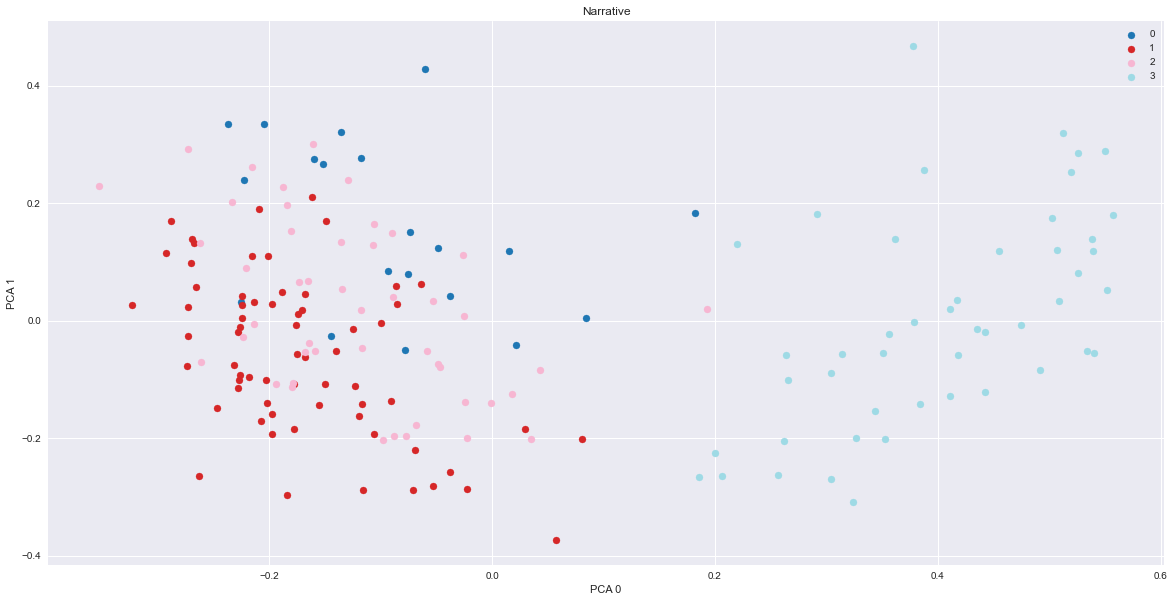

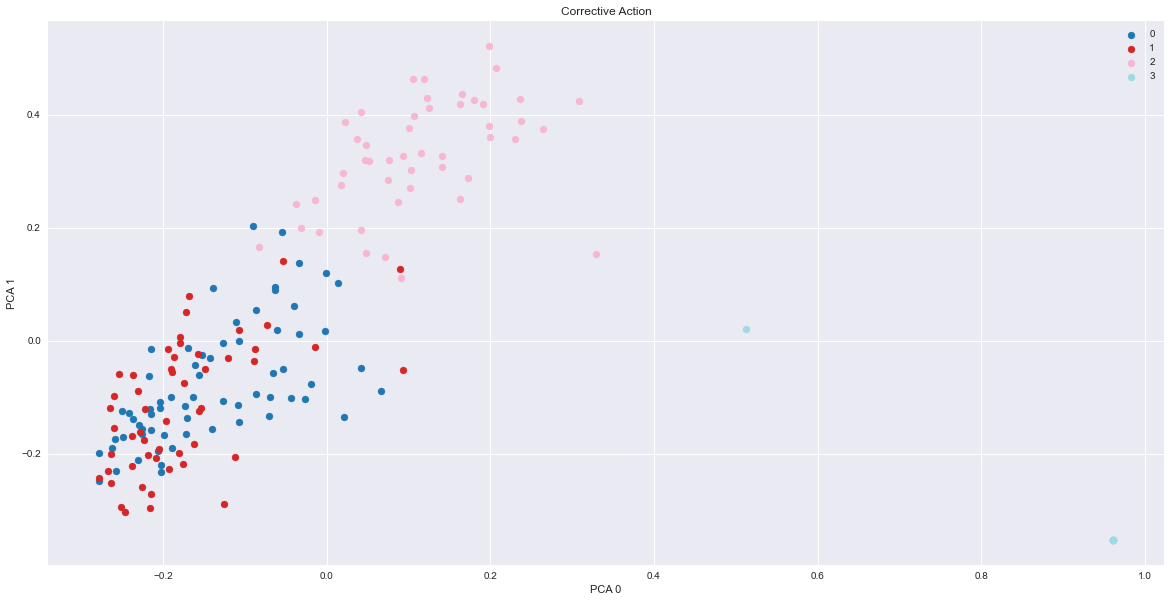

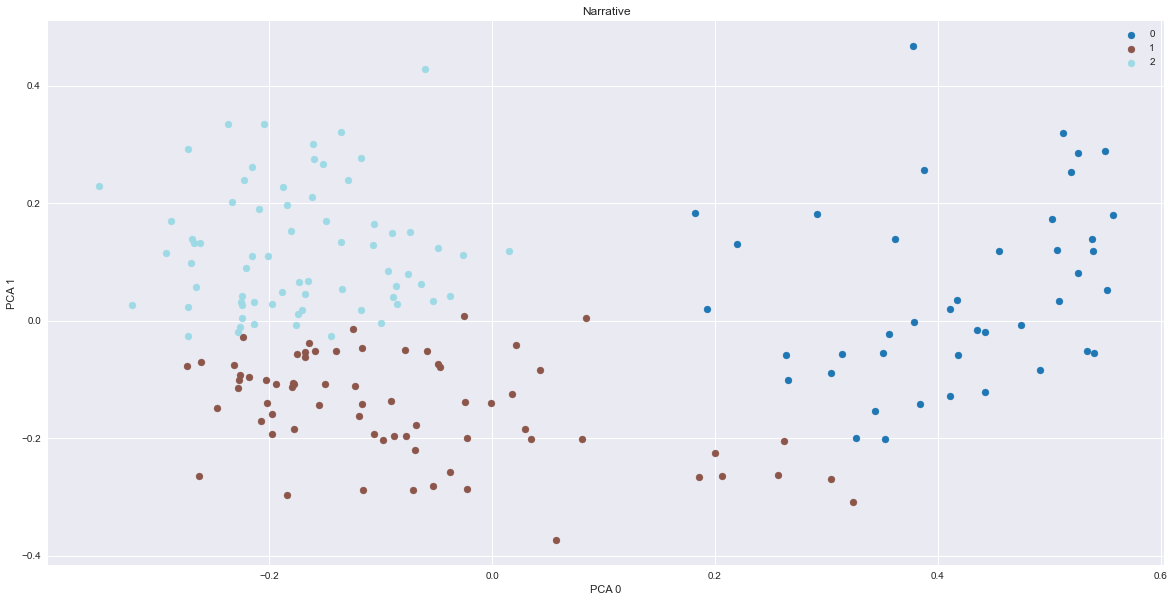

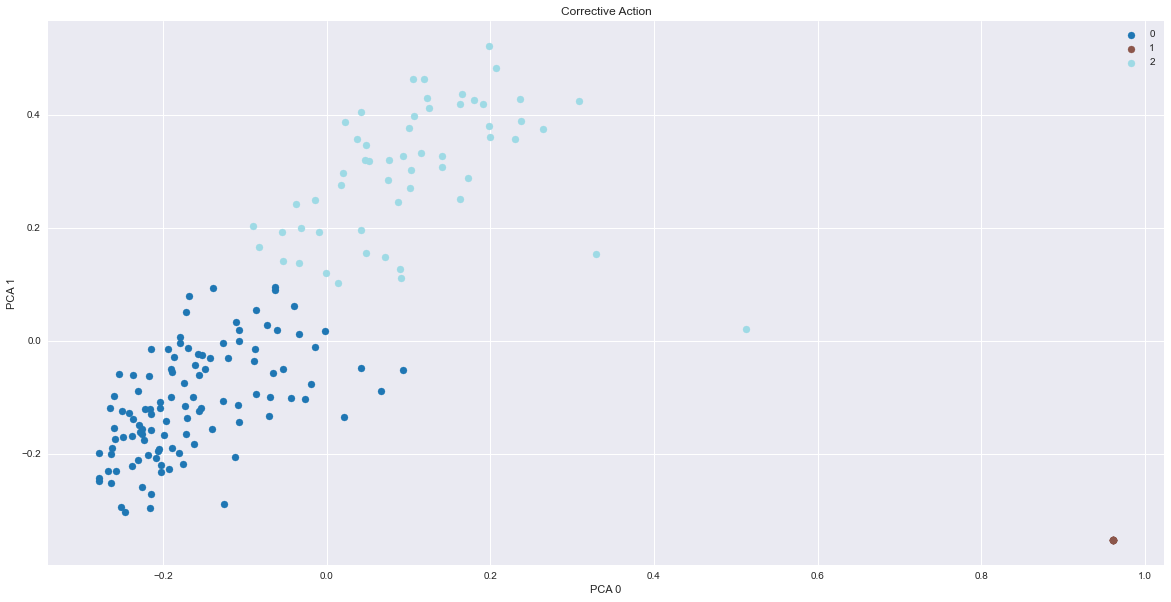

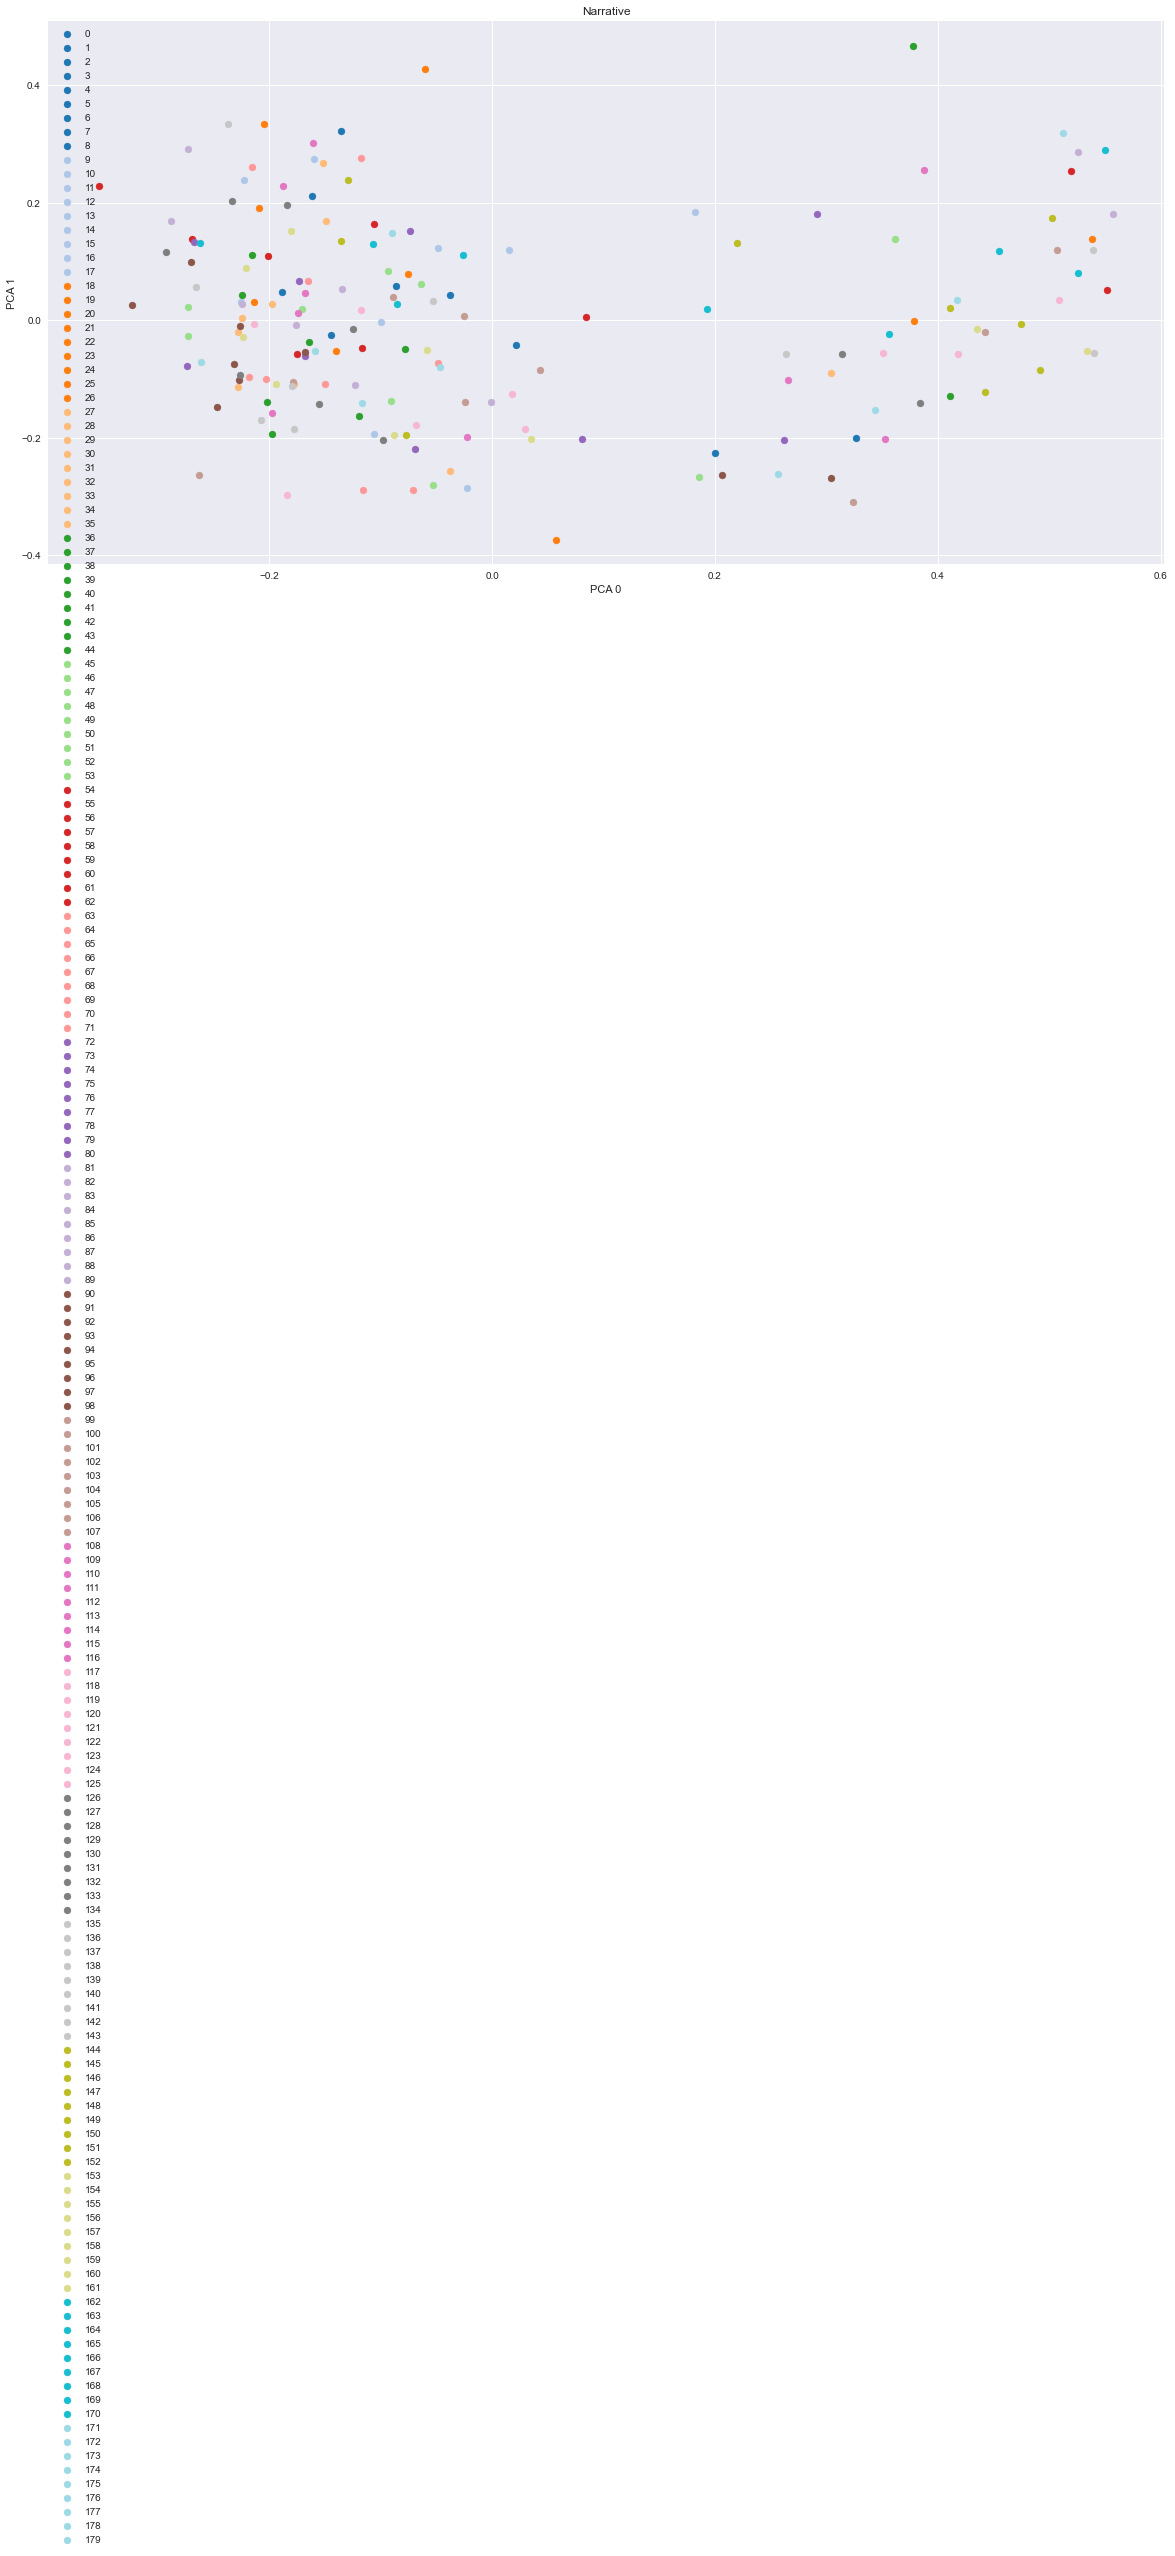

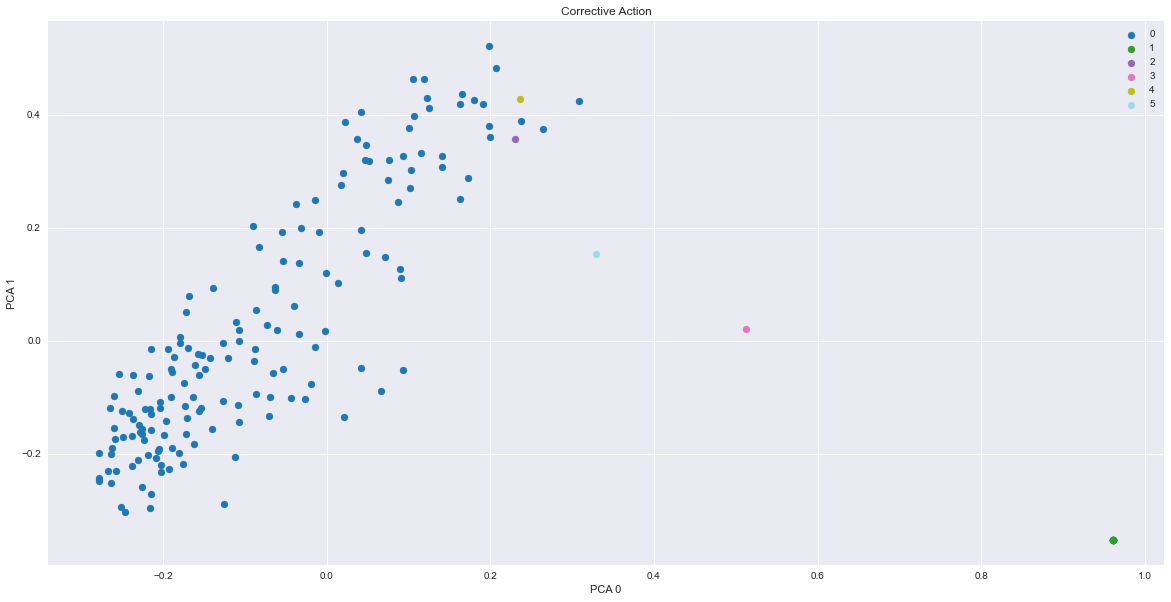

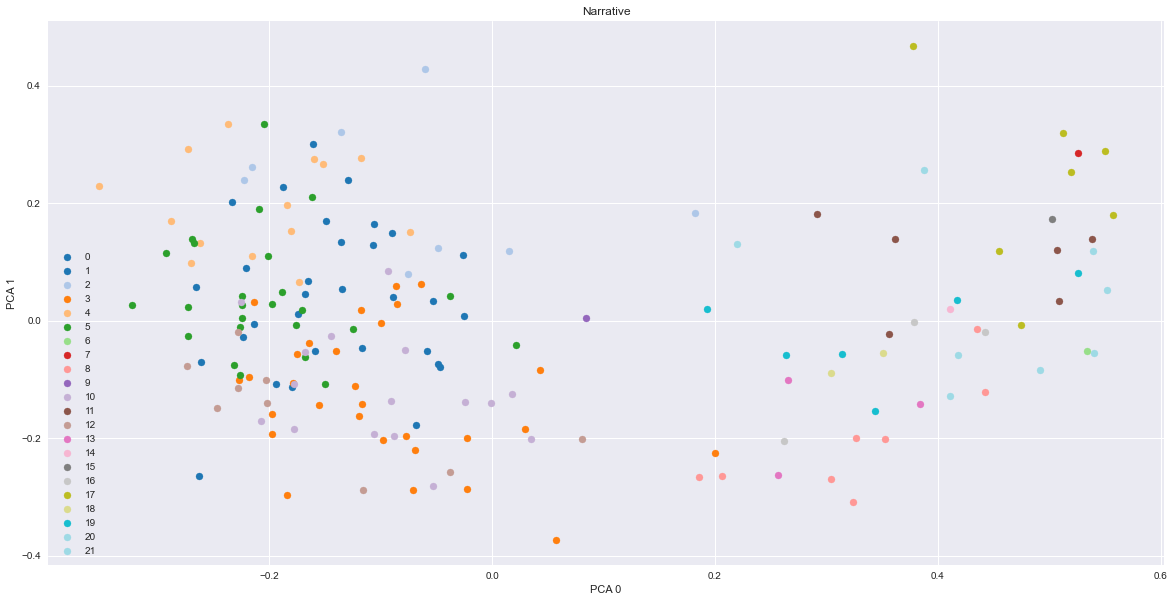

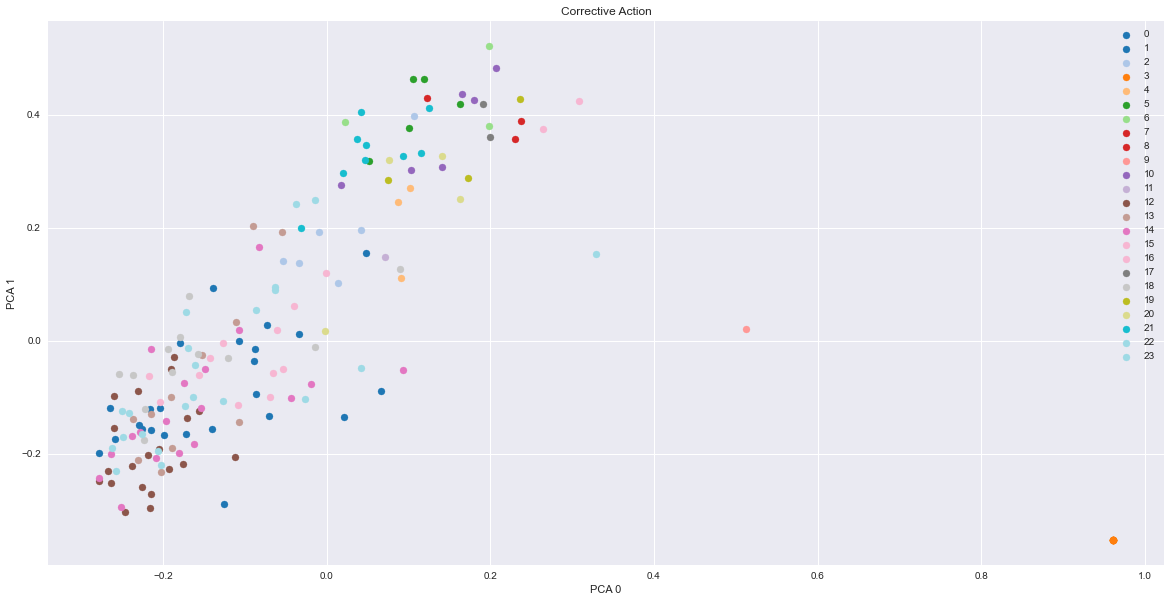

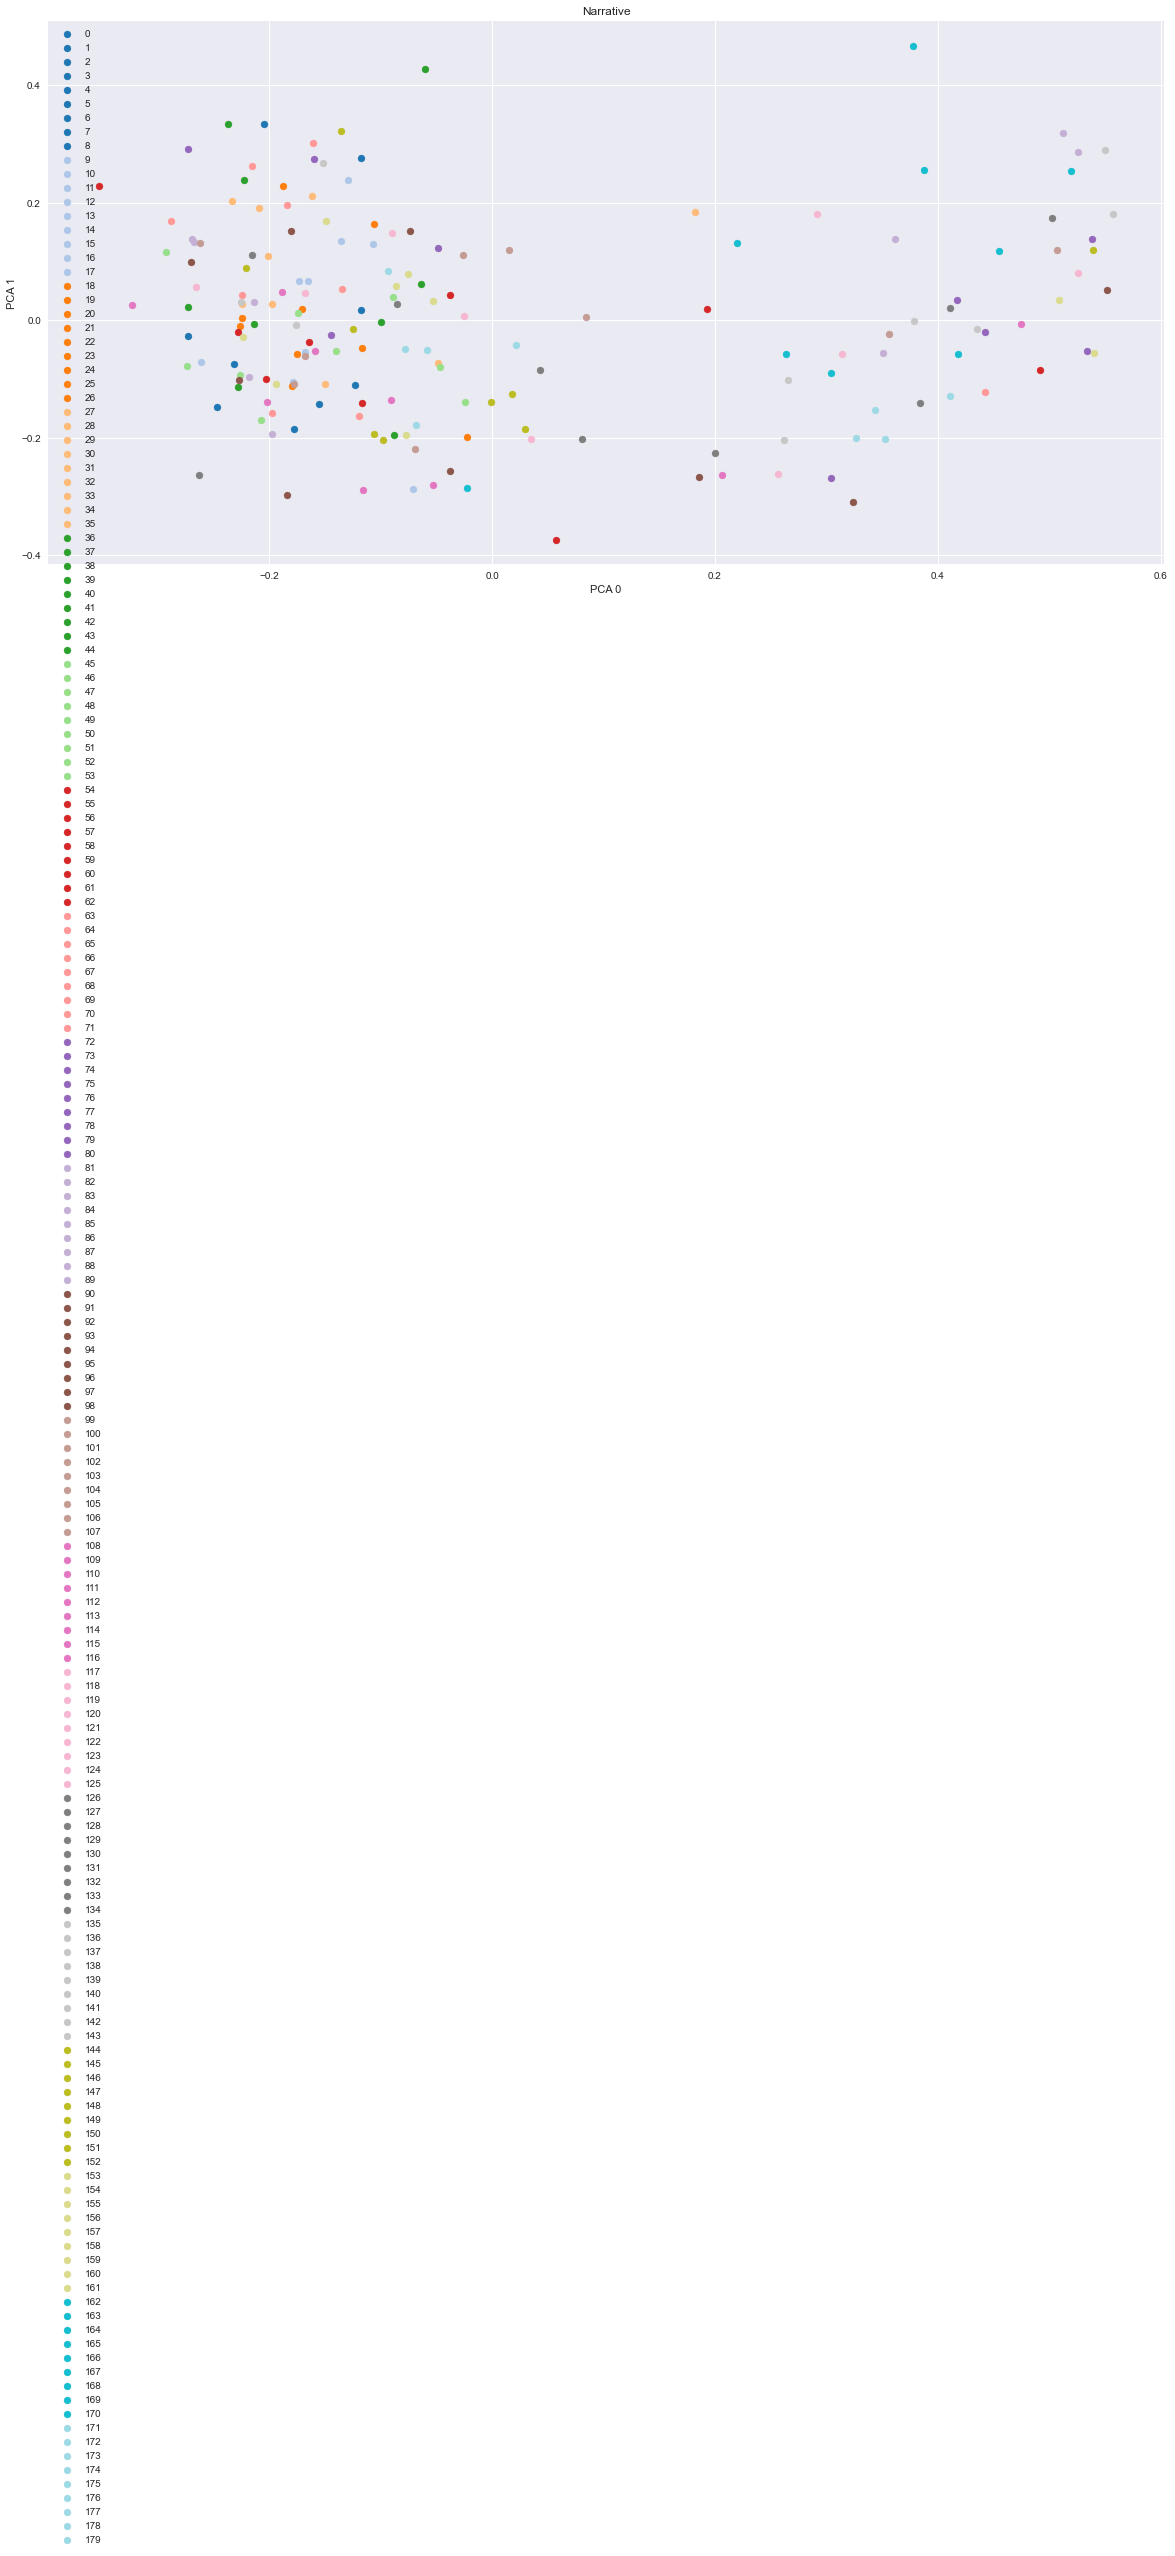

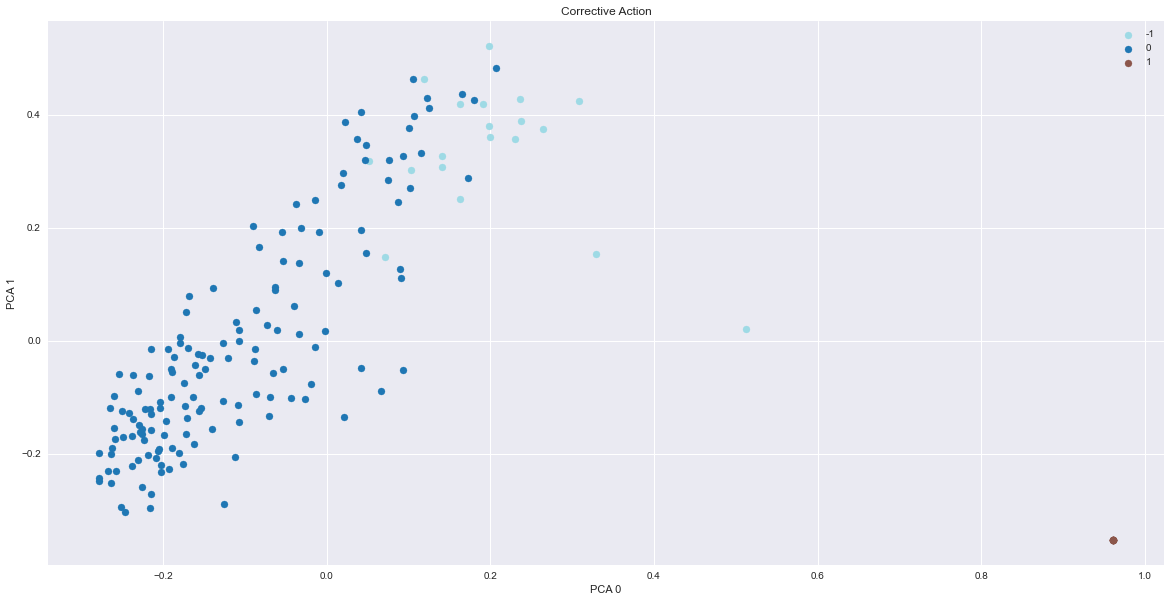

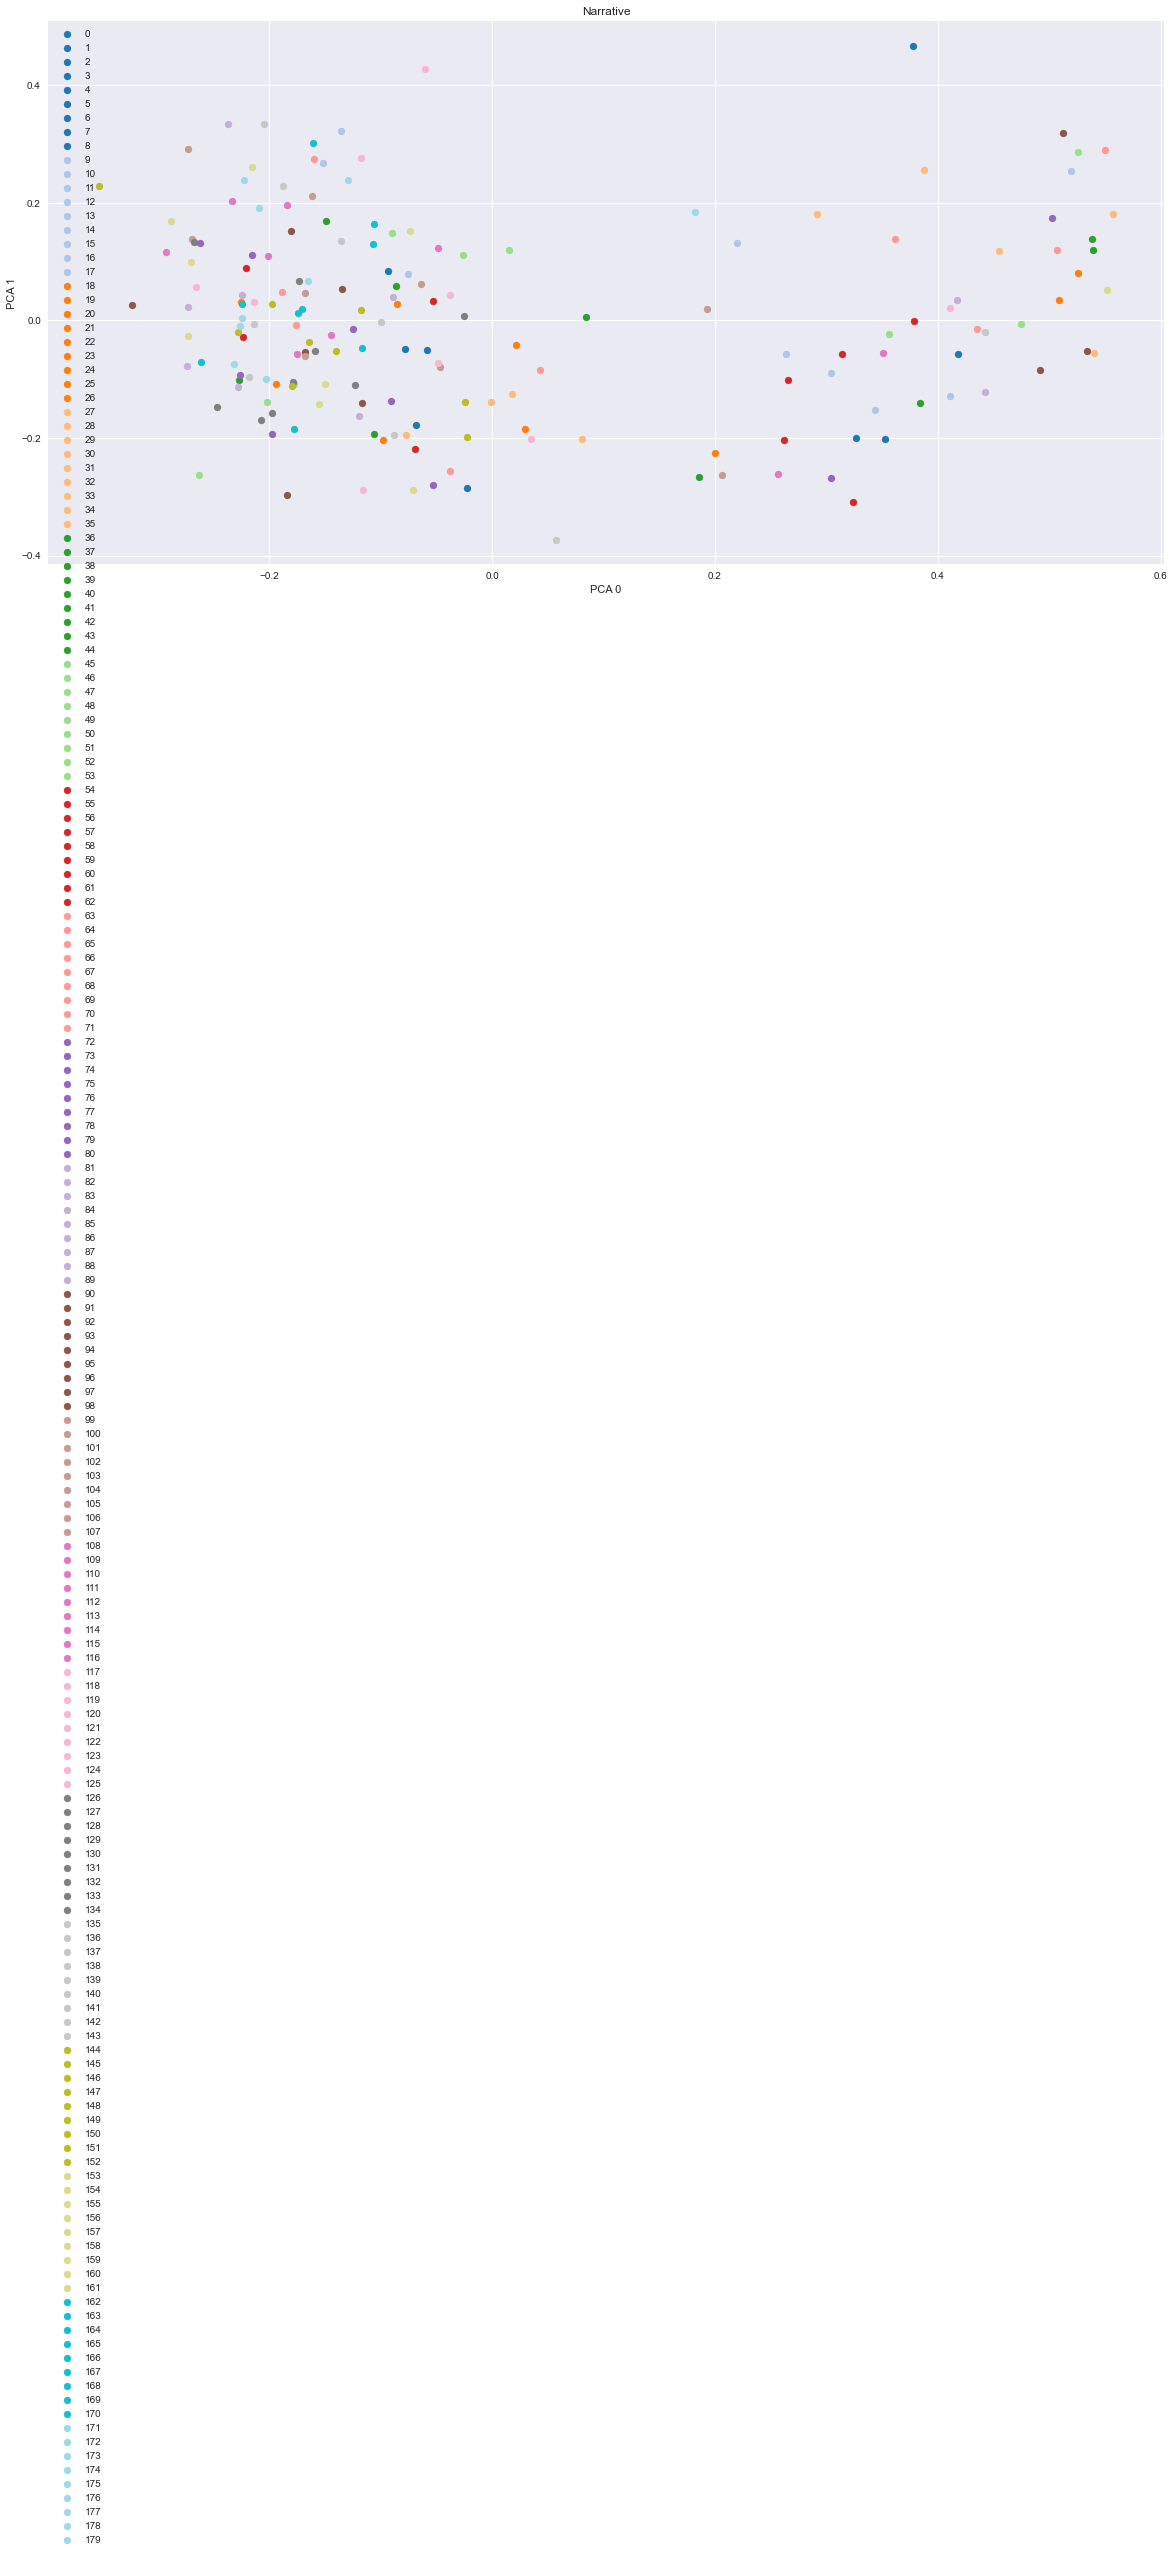

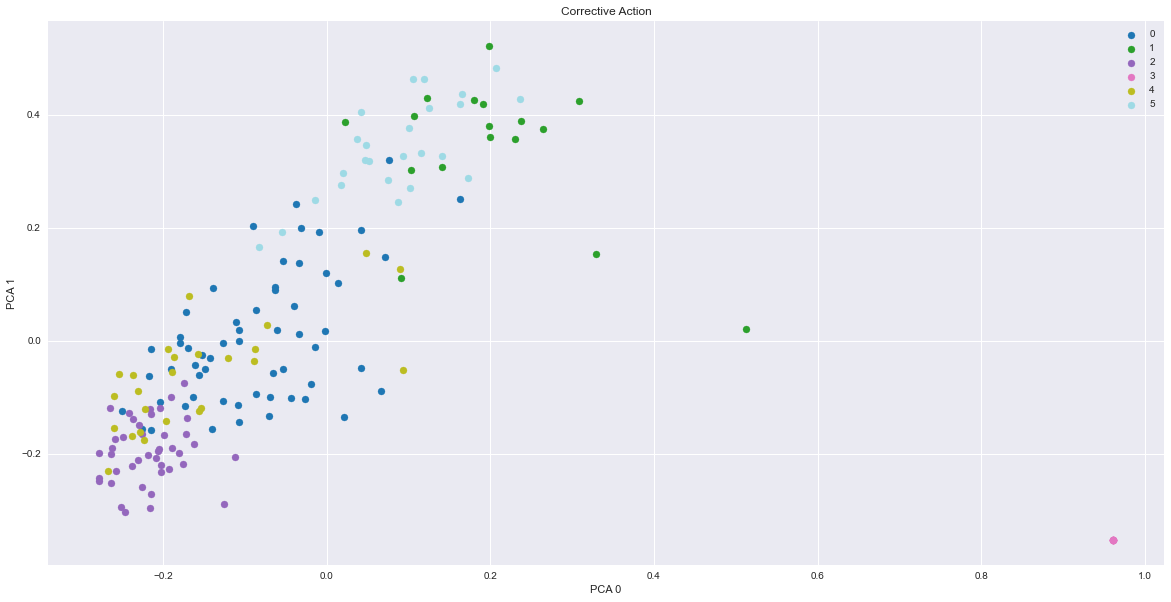

Silhouette Scores  Davies Bouldin Scores  \
Cluster Method Text Section                                                  
kmeans         Narrative                   0.056561               2.983089   
               Corrective Action           0.107109               2.707914   
spectral       Narrative                   0.049818               3.330146   
               Corrective Action           0.191029               2.241044   
mean_shift     Narrative                        NaN                    NaN   
               Corrective Action           0.201409               0.692784   
affinity       Narrative                   0.028009               2.042955   
               Corrective Action           0.104382               2.087939   
DBSCAN         Narrative                        NaN                    NaN   
               Corrective Action           0.221597               2.268404   
aglommorative  Narrative                        NaN                    NaN   
               Corrective Action           0.096356               3.049162   

                                  Calinski Harabasz Scores  
Cluster Method Text Section                                 
kmeans         Narrative                         13.854341  
               Corrective Action                 19.416410  
spectral       Narrative                         16.771565  
               Corrective Action                 24.442197  
mean_shift     Narrative                               NaN  
               Corrective Action                  7.404485  
affinity       Narrative                          4.865775  
               Corrective Action                  5.632702  
DBSCAN         Narrative                               NaN  
               Corrective Action                 18.945523  
aglommorative  Narrative                               NaN  
               Corrective Action                 13.588833

In [11]:
results_full_text, models = evaluate_cluster_methods(cluster_dict, cluster_params_dict, data, ["Narrative", "Corrective Action"], embedder, graph=True)
results_full_text

In [10]:
averages_full = [results_full_text['Silhouette Scores'].mean(),results_full_text['Davies Bouldin Scores'].mean(), results_full_text['Calinski Harabasz Scores'].mean()]
averages = [results['Silhouette Scores'].mean(),results['Davies Bouldin Scores'].mean(), results['Calinski Harabasz Scores'].mean()]
comp_df = pd.DataFrame({"Full Text": averages_full, "Summarized Text": averages}, index=['Silhouette Scores','Davies Bouldin Scores','Calinski Harabasz Scores'])
comp_df

,Full Text,Summarized Text
Silhouette Scores,0.117363,0.107505
Davies Bouldin Scores,2.378160,2.712285
Calinski Harabasz Scores,13.880203,12.646697


FMEA has components: type of operation, aircraft type, model (?), combined failure description (mode, effect, cause all in one aka summarized narrative), combined control processes/recommendations (corrective action), frequency (number in cluster), severity (calculated), risk, example id

In [30]:
data.columns

Index(['Agency', 'Unit', 'Region', 'Location', 'Date', 'Local Time',
       'Date Submitted', 'Tracking #', 'Mission Type', 'Procurement Type',
       'Persons Onboard', 'Departure Point', 'Destination', 'Special Use',
       'Damages', 'Injuries', 'Hazardous Materials', 'Other Procurement Type',
       'Other Mission Type', 'Type', 'Manufacturer', 'Model', 'Narrative',
       'Corrective Action', 'Hazard', 'Incident', 'Management', 'UAS',
       'Accident', 'Airspace', 'Maintenance', 'Mishap Prevention',
       'Extractive Summarized Narrative',
       'Extractive Summarized Corrective Action',
       'Abstractive Summarized Narrative',
       'Abstractive Summarized Corrective Action'],
      dtype='object')

In [34]:
phases_col = 'Mission Type'
fmea_data = data[['Tracking #', 'Mission Type','Type', 'Narrative', 'Corrective Action', 'Injuries', 'Damages', 'Persons Onboard', 'Hazard', 'Incident', 'Management',
              'UAS', 'Accident', 'Airspace', 'Maintenance', 'Mishap Prevention'
              ]].sort_values(phases_col).reset_index(drop=True)

In [35]:
fmea_data['Persons Onboard'] = fmea_data['Persons Onboard'].fillna(0)

In [36]:
fmea_data

,Tracking #,Mission Type,Type,Narrative,Corrective Action,Injuries,Damages,Persons Onboard,Hazard,Incident,Management,UAS,Accident,Airspace,Maintenance,Mishap Prevention
0,19-0298,"Fire, Aerial Ignition",Unmanned Aircraft System (UAS),Upon landing after an aerial ignitions mission...,1. Check propeller bolts before and after each...,No,No,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21-0019,"Fire, Aerial Ignition",Unmanned Aircraft System (UAS),UR31 arrived on DIVQ of the Red Salmon Complex...,Pilot had witnessed a similar flight failure f...,No,Yes,0.0,NaN,NaN,NaN,UAS,Accident,NaN,Rotor (Main),NaN
2,21-0027,"Fire, Aerial Ignition",Unmanned Aircraft System (UAS),2nd in flight failure in 2 days.\r\nPilot was ...,We were able to locate the aircraft. We were ...,No,No,0.0,NaN,NaN,NaN,UAS,Accident,NaN,NaN,NaN
3,17-0173,"Fire, Aerial Ignition",Helicopter,While conducting Ariel ignition on the XXXX XX...,Advised the operator to halt all drone operati...,No,No,3.0,NaN,NaN,NaN,UAS,NaN,"Conflict, UAS",NaN,NaN
4,20-1091,"Fire, Aerial Ignition",Unmanned Aircraft System (UAS),A small Unmanned Aerial Vehicle (sUAV) and a T...,"The sUAS pilot, the incident aviation managers...",No,No,0.0,NaN,NaN,NaN,"UAS, Fleet Operation",NaN,"Near Mid-Air, Congestion",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,18-0296,"Fire, Water Drop (Helicopter Bucket)",Helicopter,The local exclusive use helicopter was perform...,"As soon as the drone was spotted, one crewmemb...",No,No,1.0,NaN,NaN,NaN,Incursion,NaN,NaN,NaN,NaN
176,15-0052,"Fire, Water Drop (Helicopter Bucket)",Unmanned Aircraft System (UAS),On 11-08-2014 during the initial attack phase ...,The IC immediately confronted the individual w...,No,No,1.0,"Pilot Action, Other, Unqualified Personnel",NaN,NaN,NaN,NaN,"Intrusion, Procedures, Conflict, Congestion",NaN,Kudos
177,17-0812,"Fire, Water Drop (Helicopter Fixed-Tank)",Unmanned Aircraft System (UAS),Air Attack and 2 type 1 helicopters were flyin...,All aircraft were grounded till the situation ...,No,No,0.0,NaN,NaN,NaN,NaN,NaN,UAS,NaN,NaN
178,20-0037,"Fire, Water Drop (Helicopter Fixed-Tank)",Helicopter,"Drone Incursion: On October 31st, 2019, at 18:...",Air Attack ordered all helicopters to be groun...,No,No,2.0,NaN,NaN,NaN,Incursion,NaN,"Intrusion, UAS",NaN,NaN


In [ ]:
#BERTopic
list_of_attributes = ["Narrative", "Corrective Action"]#["Extractive Summarized Narrative", 'Extractive Summarized Corrective Action']
extra_cols = ['Agency', 'Region', 'Location', 'Date', 'Date Submitted', 'Tracking #',
              'Mission Type', 'Persons Onboard', 'Departure Point', 'Destination',
              'Special Use', 'Damages', 'Injuries', 'Hazardous Materials', 'Other Mission Type',
              'Type', 'Manufacturer', 'Model', 'Hazard', 'Incident	Management',
              'UAS', 'Accident', 'Airspace', 'Maintenance', 'Mishap Prevention'
              ]
document_id_col = 'Tracking #'
csv_file_name = os.path.join(os.path.dirname(os.getcwd()),'data','SAFECOM_UAS_fire_data.csv')
name = os.path.join('safecom_UAS_full')
safecom = Topic_Model_plus(list_of_attributes=list_of_attributes, document_id_col=document_id_col, 
                        csv_file=csv_file_name, database_name=name, extra_cols=extra_cols)
safecom.prepare_data()
bert_args = {'min_topic_size':3, 'calculate_probabilities':True}
safecom.bert_topic(BERTkwargs=bert_args)
safecom.save_bert_results()

# Method 1: NER - custom